# Cycles

In [1]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph

In [2]:
# Helper
def visualize_graph(graph):
    from IPython.display import Image, display
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

In [3]:
def add(left, right):
    return left + right


class State(TypedDict):
    total: Annotated[int, add]

In [4]:
builder = StateGraph(State)
builder.add_node("add_one", lambda x: {"total": 1})
builder.add_node("double", lambda x: {"total": x["total"]})
builder.add_edge(START, "add_one")


def route(state: State) -> Literal["double", "__end__"]:
    if state["total"] < 6:
        return "double"
    return "__end__" # This is what END is


builder.add_conditional_edges("add_one", route)
builder.add_edge("double", "add_one")

graph = builder.compile()

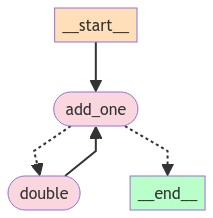

In [5]:
visualize_graph(graph)

In [7]:
thread_id = "some-thread"
config = {"configurable": {"thread_id": thread_id}}

graph.invoke({"total": 1}, config, debug=True)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'total': 1}
[0:writes] Finished step 0 with writes to 1 channel:
- total -> 1
[1:tasks] Starting step 1 with 1 task:
- add_one -> {'total': 1}
[1:writes] Finished step 1 with writes to 1 channel:
- total -> 1
[2:tasks] Starting step 2 with 1 task:
- double -> {'total': 2}
[2:writes] Finished step 2 with writes to 1 channel:
- total -> 2
[3:tasks] Starting step 3 with 1 task:
- add_one -> {'total': 4}
[3:writes] Finished step 3 with writes to 1 channel:
- total -> 1
[4:tasks] Starting step 4 with 1 task:
- double -> {'total': 5}
[4:writes] Finished step 4 with writes to 1 channel:
- total -> 5
[5:tasks] Starting step 5 with 1 task:
- add_one -> {'total': 10}
[5:writes] Finished step 5 with writes to 1 channel:
- total -> 1


{'total': 11}

#### 설명

1. 먼저, 그래프는 체크포인트를 찾습니다. 체크포인트가 발견되지 않으면 상태는 총계 0으로 초기화됩니다.
2. 다음으로, 그래프는 사용자의 입력을 상태 업데이트로 적용합니다. 리듀서는 입력 값(1)을 기존 값(0)에 추가합니다. 이 스텝의 끝에서 총계는 (1)이 됩니다.
3. 그 후, "add_one" 노드가 호출되어 1을 반환합니다.
4. 그 다음, 리듀서는 이 업데이트를 기존 총계(1)에 추가합니다. 상태는 이제 2입니다.
5. 그 다음, 조건부 에지 "route"가 호출됩니다. 값이 6보다 작으므로 'double' 노드로 이동합니다.
6. 'double'은 기존 상태(2)를 가져와 반환합니다. 리듀서가 호출되어 이를 기존 상태에 추가합니다. 상태는 이제 4가 됩니다.
7. 그래프는 다시 "add_one" (5)로 돌아가 조건부 에지를 확인하고, 값이 6보다 작으므로 계속 진행합니다. 'double' 노드를 거친 후 총계는 (10)이 됩니다.
8. 고정 에지는 다시 "add_one" (11)로 돌아가고, 조건부 엣지를 확인한 후 값이 6보다 크므로 프로그램이 종료됩니다.

이 과정을 통해 그래프는 사용자의 입력을 처리하고, 조건에 따라 다양한 노드를 통해 상태를 업데이트하며, 마지막에는 조건을 만족하지 않는 경우 프로그램이 종료됩니다.